### A 1D climate modelling example of the Sparse Hierarchical Gaussian Process

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import xarray as xr

from shgp import SHGP

2022-06-28 18:15:03.110525: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 18:15:03.110550: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 1D example

Load climate model data (1D Global mean surface temperature) from a single climate model.

Typically in climate modelling we run a model multiple times to simulate different possible climate trajectories. These are called **realisations** and they help us understand the average climate projection and the uncertainty associated with it.

Here we open a dataset which contains 9 realisations from one cliamte model. By fitting a heirarchical Gaussian processes to these realisations, we can hope to uncover the underlying climate signal that is shared amongst all the realisations. 

Though we might not need a sparse GP in this example as we're only using ~20000 datapoints, they will be useful given the size of many datasets in climate science and other disciplines.



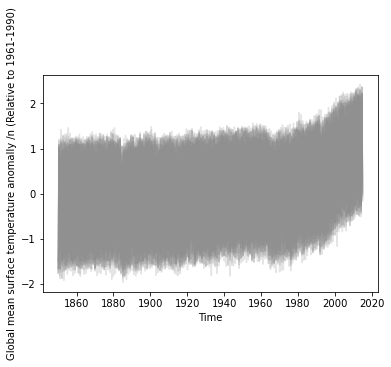

In [2]:
da = xr.open_dataarray('./../data/climate_model_data_1D_GMST.nc')

# As well as including continous time as variable, we also include 
# the sin and cos of the month number to help the GP fit periodicity
x = np.arange(len(da.time))
x_cos = np.sin(2 * np.pi * da.time.dt.month / 12)
x_sin = np.cos(2 * np.pi * da.time.dt.month / 12)

X = np.stack([x, x_cos, x_sin], axis=1)
X = x.reshape(-1, 1)
Y = da.values.T

# Normalise data
X_norm = (X - np.mean(X, axis=0))/np.std(X, axis=0)
Y_norm = (Y - np.mean(Y))/np.std(Y)

plt.figure()
plt.plot(da.time, Y_norm, color='gray', alpha=0.2)
plt.ylabel('Global mean surface temperature anomally /n (Relative to 1961-1990)')
plt.xlabel('Time')
plt.show()

### The Sparse HGP model

Using 200 inducing points

In [3]:
data = (X_norm, Y_norm)

n_inducing = 200
Z = np.linspace(np.min(X_norm, axis=0), np.max(X_norm, axis=0), n_inducing)
kernel = gpflow.kernels.Matern32()

shgp = SHGP(
    data,
    group_kernel=kernel,
    individual_kernel=kernel,
    inducing_points=Z)


params = dict()
params['optim_nits'] = 200
params['log_interval']= 20
params['learning_rate'] = 0.05

# Compilation takes some time (~1min), but fitting is fast once done
shgp.fit(params, compile=True)

2022-06-28 18:15:07.219541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-28 18:15:07.219595: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-28 18:15:07.219629: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ma-res-amosm1): /proc/driver/nvidia/version does not exist
100%|██████████| 200/200 [03:14<00:00,  1.03it/s, loss=1.3e+5]


### The predictions for each realisation

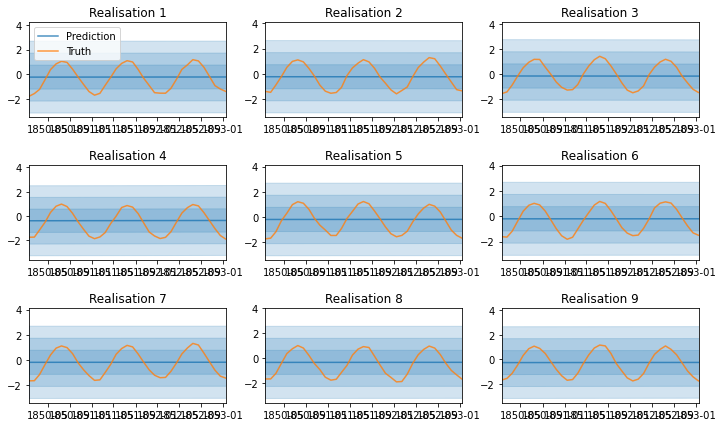

In [4]:
indi_preds = [shgp.predict_individual(X_norm, idx) for idx in range(len(da.realisation))]

plt.figure(figsize=(12,7))
for i, indi_pred in enumerate(indi_preds):
    indi_mean, indi_var = indi_pred
    indi_mean = indi_mean.numpy().squeeze()
    indi_std = np.sqrt(indi_var.numpy().squeeze())
    plt.subplot(3, 3, i + 1)
    plt.title(f'Realisation {i+1}')
    for j in range(1,4):
        plt.fill_between(da.time.values, indi_mean - j * indi_std, indi_mean + j * indi_std, alpha=0.2, color='tab:blue')
    plt.plot(da.time, indi_mean, label='Prediction', color='tab:blue', alpha=0.8)
    plt.plot(da.time, Y_norm[:, i], label='Truth', color='tab:orange', alpha=0.8)
    if i == 0:
        plt.legend()

    plt.xlim(da.time[0].values, da.time[36].values)
plt.subplots_adjust(hspace=0.5)

plt.show()

### Group prediction
This is the part of the prediction which is shared by all the indivdual realisations. In this case we might expect the group prediction to capture the climate signal that is shared by all the climate model realisations. 

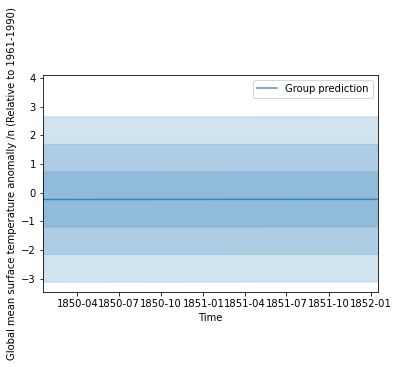

In [5]:
group_mean, group_var = shgp.predict_group(X_norm)
group_mean = group_mean.numpy().squeeze()
group_std = np.sqrt(group_var.numpy().squeeze())
for j in range(1,4):
    plt.fill_between(da.time.values, group_mean - j * group_std, group_mean + j * group_std, alpha=0.2, color='tab:blue')
plt.plot(da.time, group_mean, label='Group prediction', color='tab:blue', alpha=0.8)
plt.xlim(da.time[0].values, da.time[24].values)
plt.ylabel('Global mean surface temperature anomally /n (Relative to 1961-1990)')
plt.xlabel('Time')
plt.legend()
plt.show()